(sec_msprime_bottlenecks)=

# Instantaneous Bottlenecks

**Konrad Lohse and Jerome Kelleher**

A common approach to modelling the effect of demographic history on genealogies is to assume that effective population size ($N_e$) changes in discrete steps which define a series of epochs (Griffiths, 1994; Marth et al., 2004; Keightley & Eyre-Walker, 2007; Li & Durbin 2011). In this setting of piece-wise constant $N_e$, capturing a population bottleneck requires three epochs: $N_e$ is reduced by some fraction $b$ at the start of the bottleneck, $T_{start}$, and recovers to its initial value at time $T_{end}$ (Marth et al., 2004). If bottlenecks are short both on the timescale of coalescence and mutations, one may expect little information about the duration of a bottleneck 
in sequence data. Thus a simpler, alternative model is to assume that bottlenecks are instantaneous ($T_{end}-T_{start} \rightarrow 0$) and generate a sudden burst of coalescence events (a multiple merger event) in the genealogy. The strength of the bottleneck B can be thought of as an (imaginary) time period during which coalescence events are collapsed, i.e. there is no growth in genealogical branches during B and the probability that a single pair of lineages entering the bottleneck coalesce during the bottleneck is $1-e^{-B}$. Although this simple two parameter model of bottlenecks is attractive and both analytic results and empirical inference (Griffiths, 1994; Galtier et al., 2000; Bunnefeld et al., 2015) have been developed under this model, it has not been straightforward to simulate data under instantaneous bottleneck histories with ms. Instantaneous bottlenecks are implemented as a demographic event in msprime. Instanteous bottlenecks are similar to coalescent approximations for selective sweeps in that they generate multiple merger events. However, unlike sweeps the whole genome is effected equally. Instantanous bottlenecks differ from approximate models of sweeps (Durret & Scheinsberg, 2004) in that they do not affect the exchangeability of lineages. A consequence of this is that all topologies are equally likely (before collapsing, the imaginary bottleneck time).

Here we simulate a single sample of n=12 from a population that underwent an instantaneous bottleneck 0.4 * 2N generations ago. Note that since msprime is assuming a diploid population we set the initial population size to 1/2 to obtain coalescence times scaled in units of $2N_e$ generations:

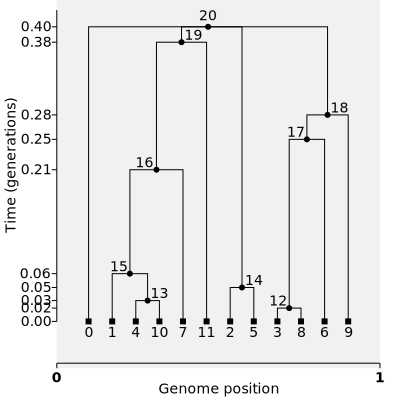

In [1]:
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG

def run_bott_sims(num_samp, time, strength, num_rep=None, seed=123):    
    demography = msprime.Demography()
    demography.add_population(initial_size=1/2)
    demography.add_instantaneous_bottleneck(time=time, strength=strength, population=0)
    return msprime.sim_ancestry(
        samples=[msprime.SampleSet(num_samp, ploidy=1)],  # Sample num_samp haploid genomes
        ploidy=2,
        num_replicates=num_rep,
        demography=demography,
        random_seed=seed)

bottT = 0.4
bottB = 2

ts = run_bott_sims(12, time=bottT, strength=bottB)

ts.draw_svg(y_axis=True, size=(400, 400))

The genealogy shows several simultaneous coalescence events at the time of the bottleneck
(T=0.4)


## Checking the SFS against analytic expectation

Bunnefeld et al (2016) derive the total length of n-ton branches under an instantaneous bottleneck using a recursion for the generating function of genealogies. Assuming a sample size of $n=4$, $B=4$ and $T=0.4$, the SFS is:

In [2]:
T=bottT
B = 4
s=1-np.exp(-B)
p=s*(-6 + 15*s - 20 * np.power(s,2) + 15 * np.power(s,3) - 6 * np.power(s,4) + np.power(s,5))

expsfsBottlN= [2/15*(np.exp(-6*T)*(15 *np.exp(6*T) - 9 *np.exp(5*T)*s - 
    5*np.exp(3*T)*s*(3 - 3*s + np.power(s,2)) + p)),
    1/5*np.exp(-6*T)*(5*np.exp(6*T) - 6*np.exp(5*T)*s - p),
    2/15*np.exp(-6*T)*(5*np.exp(6*T) - 9*np.exp(5*T)*s + 5*np.exp(3*T)*s*(3-3*s + np.power(s,2))+ p)]

expsfsBottlN/=np.sum(expsfsBottlN)
print(expsfsBottlN)

[0.7722266  0.17689752 0.05087588]


Checking against msprime (10,000 replicates) shows a close fit to this analytic expectation:

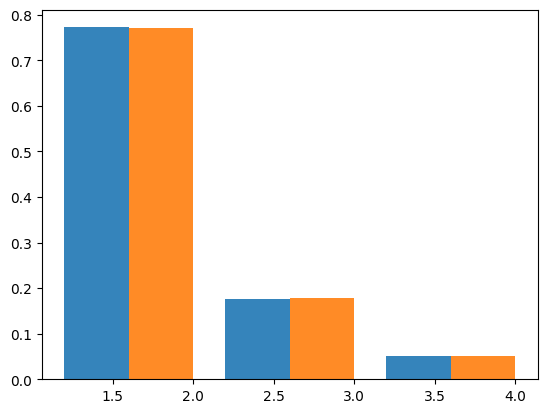

In [3]:
nrep = 10_000
nsamp = 4
sims = run_bott_sims(nsamp, time=T, strength=B, num_rep=nrep)
Blist=np.zeros((nrep, nsamp+1))
for rep_index, ts in enumerate(sims):
    afs=ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False)
    Blist[rep_index]+= afs

data=np.mean(Blist, axis=0)
data/=np.sum(data)

fig, ax = plt.subplots()
index = np.arange(1,4)
bar_width = 0.4
opacity = 0.9

expsfs = ax.bar(index+ bar_width, expsfsBottlN, bar_width, alpha=opacity, label='exp')
simsfs = ax.bar(index+ 2*bar_width, data[1:4], bar_width, alpha=opacity, label='exp')

## Expected coalescence times

The expected pairwise coalescence time is $E[t]= 1 + e^{-(B+T)} - e^{-T}$. Both the expected
coalescence time and the probability that a pair of lineages survives the bottleneck fit
the analytic expectation closely:

In [4]:
def pairCoalBott(time, strength, num_rep=1000):
    """
    Simulates replicate 2-tip tree sequences under an instantaneous bottleneck returning the TMRCA
    """
    reps=run_bott_sims(2, time=time, strength=strength, num_rep=num_rep)
    B = np.zeros(num_rep)
    for j, ts in enumerate(reps):
        tree = next(ts.trees())
        B[j] = tree.time(tree.root)
    return(B)

nrep=1000

#Recording the mean pairwise coalescence times and the fraction of replicates with t>T for a grid of bottleneck strengths:
bottBlist = np.arange(0.0,5,0.25)
dat = np.zeros(len(bottBlist))
prob = np.zeros(len(bottBlist))
for j in range(len(bottBlist)):
    mrcas = pairCoalBott(bottT, bottBlist[j], nrep)
    dat[j]=np.mean(mrcas, axis=0)
    prob[j]=len(mrcas[mrcas>bottT])/nrep

bottT2 = bottT * 2  # 0.8
dat2 = np.zeros(len(bottBlist))
prob2 = np.zeros(len(bottBlist))
for j in range(len(bottBlist)):
    mrcas = pairCoalBott(bottT2, bottBlist[j], nrep)
    dat2[j]=np.mean(mrcas, axis=0)
    prob2[j]=len(mrcas[mrcas>bottT2])/nrep

expProb = [np.exp(-(bottT+i)) for i in bottBlist]
expProb2 = [np.exp(-(bottT2+i)) for i in bottBlist]

expMean = [1+np.exp(-(bottT+i))-np.exp(-bottT) for i in bottBlist]
expMean2 = [1+np.exp(-(bottT2+i))-np.exp(-bottT2) for i in bottBlist]

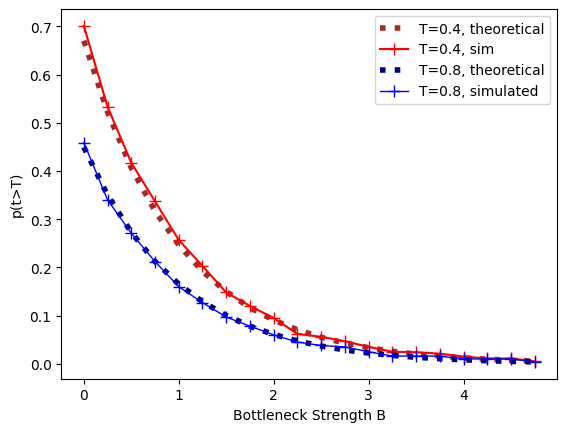

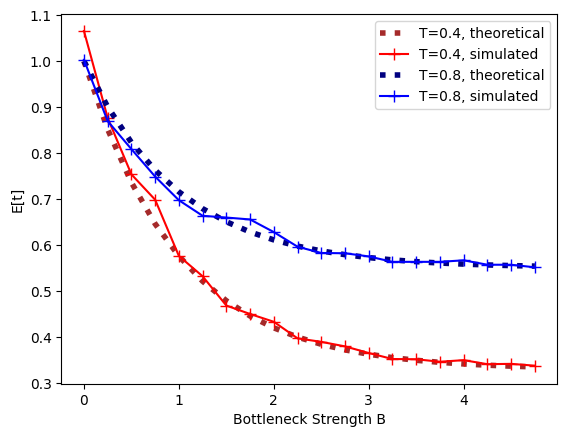

In [5]:
plt.plot(bottBlist, expProb, c='brown', ls=":", lw=4, label=f"T={bottT}, theoretical")
plt.plot(bottBlist, prob, c='red', marker='+', ms=8, label=f"T={bottT}, sim")
plt.plot(bottBlist, expProb2, c='navy', ls=":", lw=4, label=f"T={bottT2}, theoretical")
plt.plot(bottBlist, prob2, c='blue', marker='+', lw=1, ms=8, label=f"T={bottT2}, simulated")
plt.xlabel("Bottleneck Strength B")
plt.ylabel("p(t>T)")
plt.legend()
plt.show()

plt.plot(bottBlist, expMean, c='brown', ls=":", lw=4, label=f"T={bottT}, theoretical")
plt.plot(bottBlist, dat, c='red', marker='+', ms=8, label=f"T={bottT}, simulated")
plt.plot(bottBlist, expMean2, c='navy', ls=":", lw=4, label=f"T={bottT2}, theoretical")
plt.plot(bottBlist, dat2, c='blue', marker='+', ms=8, label=f"T={bottT2}, simulated")
plt.xlabel("Bottleneck Strength B");
plt.ylabel("E[t]")
plt.legend()
plt.show()

## The distribution of pairwise coalescence times

The distribution of pairwise coalescence times has two maxima at $t=0$ and the bottleneck time $t=T$ (we have assumed $T=0.8$ below) as expected. The simulated distribution of pairwise coalescence times fits the analytic expectation:

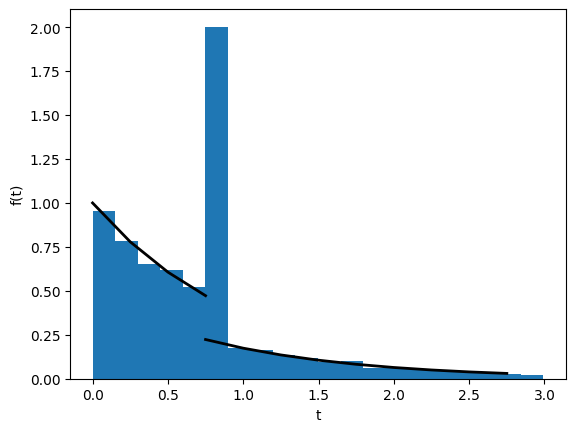

In [6]:
s = bottBlist[3]
sprob = 1-np.exp(-s)

coaldis = pairCoalBott(s, bottT2, 10000);
coaldisFilt = coaldis[(coaldis < 3)];

probtest = len(coaldis[coaldis>bottT2])/10000
expprob2 = np.exp(-(bottT2+s))

tlist = np.arange(0.0,3,0.25);
coalEpx1 = [np.exp(-i) for i in tlist[0:4]];
coalEpx2 = [np.exp(-i)-(sprob*np.exp(-i)) for i in tlist[3:]];

plt.plot(tlist[0:4], coalEpx1, color = 'black', linewidth = 2);
plt.plot(tlist[3:], coalEpx2, color = 'black', linewidth = 2);
plt.hist(coaldisFilt, bins = 20, density=True);
plt.xlabel("t");
plt.ylabel("f(t)")
plt.show()

## Approximating the site frequency spectrum

Bottlenecks can have a substantial effect on the site frequency spectrum (SFS). The SFS is a fundamental summary of sequence variation that forms the basis of many modern inference approaches (e.g. sweepfinder, DFE-alpha, dadi). in the absence of linkage information the SFS is a lossless summary, i.e. any summary of sequence variation that ignores linkage (e.g. pairwise measures of diversity and divergence, $F_{st}$, Tajima's D etc) are summaries of the SFS (Achaz 2009). The SFS is convenient analytically, since it depends only on the mean length and frequency of genealogical branches. For many demographic models of interest the mean length of n-ton branches can be derived either using coalescent theory (Chen 2011) or diffusion equations (Gutenkunst 2009). A number of composite likelihood approaches have been developed based on either analytic results for the SFS or approximate obtained from coalescent simulations (Gutenkunst 2009, Excoffier 2002). We can use msprime to obtain the SFS for a sample of $n=20$ for a range of bottleneck strengths:

In [7]:
def bottSFS(num_samp, time, strength, num_rep):
    reps = run_bott_sims(num_samp, time=time, strength=strength, num_rep=num_rep)
    Blist = np.zeros((num_rep, num_samp+1))
    for rep_index, ts in enumerate(reps):
        afs=ts.allele_frequency_spectrum(mode="branch", polarised=True, span_normalise=False)
        Blist[rep_index]+= afs
    data = np.mean(Blist, axis=0)
    data /=np.sum(data)
    return data[0:num_samp]

nrep = 5_000
nsamp = 12
bottT = 0.8

bottBlist = np.arange(0.0,5,1)
datalist = {}
for s in bottBlist:
    datalist[s]= bottSFS(nsamp, bottT, s, nrep)

With increasing bottleneck strength the SFS becomes increasingly skewed (the leftmost blue bars show the SFS for a population of constant size). However, bottlenecks have a complex effect on the different frequency classes of the SFS: while the relative frequency of singletons increases, other frequency classes (e.g. doubletons) have a non-monotonic relationship with B:

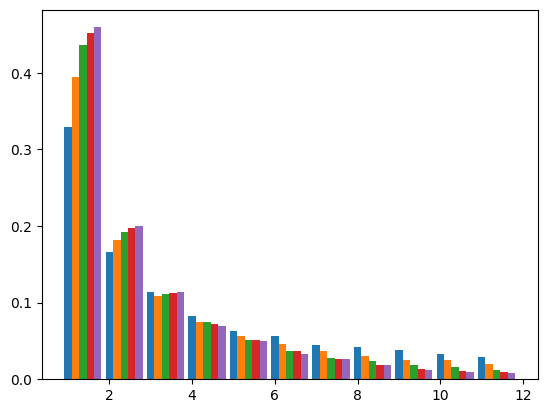

In [8]:
bar_width=0.18
index = np.arange(1, nsamp)
j = 0
for ss, y in datalist.items():
    plt.bar(index + j * bar_width, y[1:], bar_width, label=str(ss))
    j += 1

## The marginal distribution of n-ton branch lengths

We may be interested in the marginal distributions (pdf) of branch lengths immediately
above a node with n tips, which determines the expected distribution of n-ton mutations in a
nonrecombining block of sequence (Bunnefeld et al., 2016). Like the distribution of
pairwise coalescence times, we expect the pdf of n-ton branches to be discontinuous.
Assuming n=4, B=0.75 and T=0.8 (as above):

In [9]:
bottB = 0.8
bottT = 0.75
numrep = 20_000
nsamp = 4
sims = run_bott_sims(nsamp, bottT, bottB, num_rep=numrep)
B = np.zeros((numrep, nsamp))
for rep_index, ts in enumerate(sims):
    tree = next(ts.trees())
    for u in tree.nodes():
        nleaves = tree.num_samples(u)
        if tree.parent(u) != tskit.NULL:
            B[rep_index, nleaves] += tree.branch_length(u)  # Branch length above this node
            
Btrans=np.array(B).T.tolist()

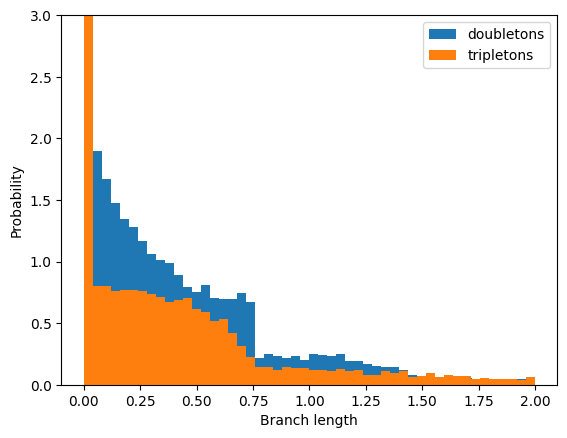

In [10]:
plt.hist([x for x in sorted(Btrans[2]) if x < 2], bins = 50, density=True, label="doubletons");
plt.hist([x for x in sorted(Btrans[3]) if x < 2], bins = 50, density=True, label="tripletons");
plt.ylim(0, 3)
plt.ylabel("Probability")
plt.xlabel("Branch length")
plt.legend()
plt.show()

Again, this gives a good fit to the analytic expectation (see Bunnefeld at al 2016).

## Multiple populations

The ``InstantaneousBottleneck`` model does not work without specifying any populations. Measuring bottleneck strength in generations (i.e. an imaginary time of coalescence) has a subtle but important consequence when we consider samples from multiple populations: the effect of the bottleneck on lineages present in each population at time T depends on the size of each population: genealogies in small populations are more strongly affected.